In [ ]:
pip install helper

**importing the important libraries**

In [1]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import helper
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv


**Reading the dataset**

In [3]:
dataframe=pd.read_csv('/content/covid_19_clean_complete.csv', parse_dates=['Date'])
dataframe['Province/State']=dataframe['Province/State'].fillna('')
dataframe.rename(columns={'Country/Region':'Country','Province/State':'State'},inplace=True)
dataframe

State                Country        Lat  ...  Confirmed Deaths  Recovered
0                      Afghanistan  33.000000  ...          0      0          0
1                          Albania  41.153300  ...          0      0          0
2                          Algeria  28.033900  ...          0      0          0
3                          Andorra  42.506300  ...          0      0          0
4                           Angola -11.202700  ...          0      0          0
...     ...                    ...        ...  ...        ...    ...        ...
32060        Sao Tome and Principe   0.186360  ...        251      8          4
32061                        Yemen  15.552727  ...        197     33          0
32062                      Comoros -11.645500  ...         34      1          8
32063                   Tajikistan  38.861034  ...       2350     44          0
32064                      Lesotho -29.609988  ...          1      0          0

[32065 rows x 8 columns]

In [4]:
q=dataframe.query('Country=="Mexico"')
df=q.fillna('').groupby(['Date'])['Confirmed'].max()
df=pd.DataFrame(df)
df

Confirmed
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17      49219
2020-05-18      51633
2020-05-19      54346
2020-05-20      56594
2020-05-21      59567

[121 rows x 1 columns]

**Spliting the dataset**

In [5]:
train=df[0:97]
test=df[97:]
test

Confirmed
Date                 
2020-04-28      16752
2020-04-29      17799
2020-04-30      19224
2020-05-01      20739
2020-05-02      22088
2020-05-03      23471
2020-05-04      24905
2020-05-05      26025
2020-05-06      27634
2020-05-07      29616
2020-05-08      31522
2020-05-09      33460
2020-05-10      35022
2020-05-11      36327
2020-05-12      38324
2020-05-13      40186
2020-05-14      42595
2020-05-15      45032
2020-05-16      47144
2020-05-17      49219
2020-05-18      51633
2020-05-19      54346
2020-05-20      56594
2020-05-21      59567

In [7]:
# Series to test
column_name = df.columns[0]
print("%s cases will be used for the analysis" % column_name)

Confirmed cases will be used for the analysis


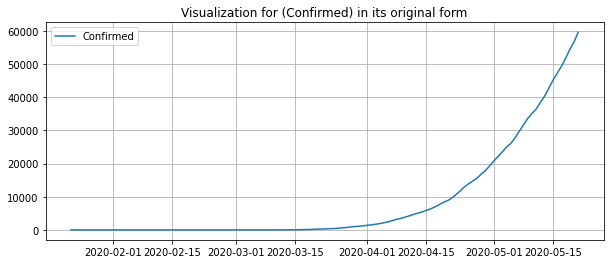

In [8]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [9]:
df.tail()

Confirmed
Date                 
2020-05-17      49219
2020-05-18      51633
2020-05-19      54346
2020-05-20      56594
2020-05-21      59567

In [10]:
df_to_test = copy.deepcopy(df)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [11]:
df_to_test.tail()

Confirmed
Date                 
2020-05-17      49219
2020-05-18      51633
2020-05-19      54346
2020-05-20      56594
2020-05-21      59567

In [12]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [13]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [14]:
#Mean absolute percentage error (MAPE)
def mape(actual, predicted): 
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [16]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [17]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [18]:
print(column_name)
results = grid_search(df_to_test)

Confirmed
([(0, 0, 0), (0, 0, 0, 365), 'n'], 17155.984050099625, 8537.950413223141)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 17155.984050099625, 8537.950413223141)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 14860.30754229541, 11059.679530086742)
([(0, 0, 0), (0, 0, 0, 365), 't'], 11052.102368986214, 8742.122334456562)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 9491.047100413549, 7648.846278320983)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 29612.89919668647, 14663.358488293476)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 7905.19324289626, 5874.7344802749385)
([(0, 0, 1), (0, 0, 0, 365), 't'], 5694.189459710871, 4603.275129378977)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 5226.580992422127, 4162.050687604416)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 4747.323083880247, 2372.4028406474317)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 4794.463945902644, 3583.534554884957)
([(0, 0, 2), (0, 0, 0, 365), 't'], 3101.6224273530343, 2552.7387784383186)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 3502.872868776485, 2458.200588845491)
([(0, 1, 0), (0, 0, 0, 365), '

In [19]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Confirmed
[(1, 1, 2), (0, 0, 0, 365), 'ct'] 128.84791928996532 78.71132398697868


In [20]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

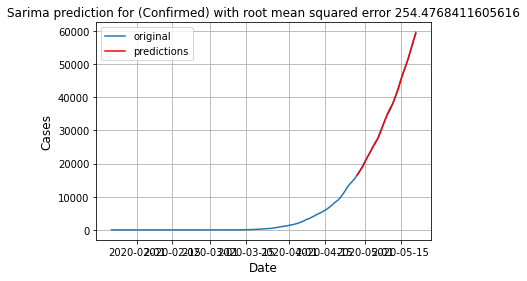

In [21]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(test, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cases', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [22]:
mape(test,predictions)

47.460919918718425

In [ ]:
#Recovered Cases in Mexico'''

RECOVERED CASES

In [27]:
q=dataframe.query('Country=="Mexico"')
dfr=q.fillna('').groupby(['Date'])['Recovered'].max()
dfr=pd.DataFrame(dfr)
dfr

Recovered
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17      33329
2020-05-18      35388
2020-05-19      37325
2020-05-20      38419
2020-05-21      40152

[121 rows x 1 columns]

**Spliting the datatset**

In [28]:
trainr=dfr[0:97]
testr=dfr[97:]
testr

Recovered
Date                 
2020-04-28      11423
2020-04-29      11423
2020-04-30      11423
2020-05-01      12377
2020-05-02      12377
2020-05-03      13447
2020-05-04      13447
2020-05-05      16810
2020-05-06      17781
2020-05-07      17781
2020-05-08      20314
2020-05-09      21824
2020-05-10      21824
2020-05-11      23100
2020-05-12      25935
2020-05-13      26990
2020-05-14      28475
2020-05-15      30451
2020-05-16      31848
2020-05-17      33329
2020-05-18      35388
2020-05-19      37325
2020-05-20      38419
2020-05-21      40152

In [29]:
# Series to test
column_name = dfr.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Recovered cases will be used for the analysis


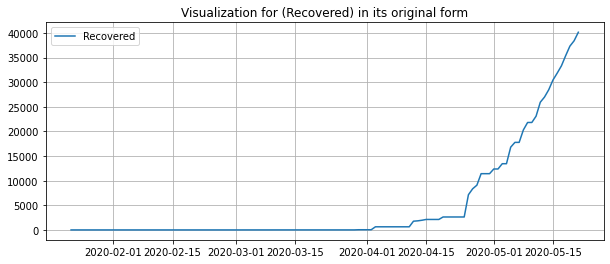

In [30]:
plt.figure(figsize=(10,4))
plt.plot(dfr, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfr.columns[0])
plt.grid()
plt.show()

In [31]:
dfr.tail()

Recovered
Date                 
2020-05-17      33329
2020-05-18      35388
2020-05-19      37325
2020-05-20      38419
2020-05-21      40152

In [32]:
df_to_test = copy.deepcopy(dfr)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [33]:
df_to_test.tail()

Recovered
Date                 
2020-05-17      33329
2020-05-18      35388
2020-05-19      37325
2020-05-20      38419
2020-05-21      40152

In [34]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [35]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [36]:
def sarima_configs(seasonal=None):
    """Generate all possible combinations of hyperparameters
    """
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [37]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [38]:
print(column_name)
results = grid_search(df_to_test)

Recovered
([(0, 0, 0), (0, 0, 0, 365), 'n'], 11188.878889399639, 5074.520661157025)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 11188.878889399639, 5074.520661157025)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 9961.296836420843, 7251.283996994741)
([(0, 0, 0), (0, 0, 0, 365), 't'], 7846.827580543265, 6025.250254473321)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 6932.875559619459, 5427.3126543046565)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 5887.2390676759715, 2650.2085963199324)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 5340.264883463338, 3820.6502697509372)
([(0, 0, 1), (0, 0, 0, 365), 't'], 4170.822656404401, 3228.715588064673)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 3827.2976788349342, 2910.5203558679186)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 3510.4665917617826, 1554.3358000981143)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 3312.436495689158, 2340.9314755623273)
([(0, 0, 2), (0, 0, 0, 365), 't'], 2605.867337522834, 2046.4978476280228)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 13826.783596929163, 10505.898524051356)
([(0, 1, 0), (0, 0, 0, 3

In [40]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Recovered
[(2, 0, 2), (0, 0, 0, 365), 'ct'] 564.0905617875595 275.20393121599284


In [41]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

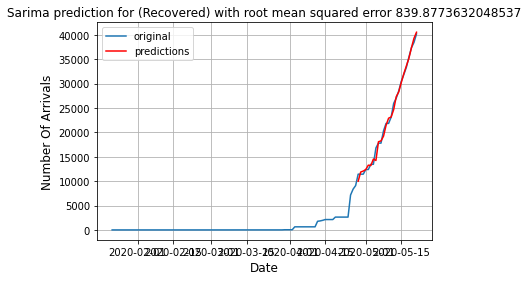

In [42]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testr, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [43]:
mape(testr,predictions)

54.32357061490543

In [ ]:
# Deaths cases

DEATH CASES

In [45]:
q=dataframe.query('Country=="Mexico"')
dfd=q.fillna('').groupby(['Date'])['Deaths'].max()
dfd=pd.DataFrame(dfd)
dfd

Deaths
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
...            ...
2020-05-17    5177
2020-05-18    5332
2020-05-19    5666
2020-05-20    6090
2020-05-21    6510

[121 rows x 1 columns]

In [46]:
# Series to test
column_name = dfd.columns[0]
print("%s cases will be used for the analysis" % column_name)

Deaths cases will be used for the analysis


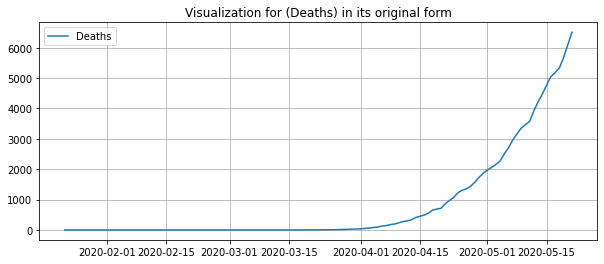

In [47]:
plt.figure(figsize=(10,4))
plt.plot(dfd, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfd.columns[0])
plt.grid()
plt.show()

In [48]:
dfd.tail()

Deaths
Date              
2020-05-17    5177
2020-05-18    5332
2020-05-19    5666
2020-05-20    6090
2020-05-21    6510

In [49]:
df_to_test = copy.deepcopy(dfd)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [50]:
df_to_test.tail()

Deaths
Date              
2020-05-17    5177
2020-05-18    5332
2020-05-19    5666
2020-05-20    6090
2020-05-21    6510

**Spliting the dataset**

In [52]:
traind=dfd[0:97]
testd=dfd[97:]
testd

Deaths
Date              
2020-04-28    1569
2020-04-29    1732
2020-04-30    1859
2020-05-01    1972
2020-05-02    2061
2020-05-03    2154
2020-05-04    2271
2020-05-05    2507
2020-05-06    2704
2020-05-07    2961
2020-05-08    3160
2020-05-09    3353
2020-05-10    3465
2020-05-11    3573
2020-05-12    3926
2020-05-13    4220
2020-05-14    4477
2020-05-15    4767
2020-05-16    5045
2020-05-17    5177
2020-05-18    5332
2020-05-19    5666
2020-05-20    6090
2020-05-21    6510

In [53]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [54]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [56]:
#Generate all possible combinations of hyperparameters
  
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [57]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [58]:
print(column_name)
results = grid_search(df_to_test)

Deaths
([(0, 0, 0), (0, 0, 0, 365), 'n'], 1763.0519955018272, 834.0247933884298)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 1763.0519955018272, 834.0247933884298)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 1551.4529462336698, 1132.0036199713134)
([(0, 0, 0), (0, 0, 0, 365), 't'], 1192.4142474641797, 919.5196174690071)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 1040.3752967230807, 819.8804250293463)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 911.9518714488324, 432.80239714546155)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 1564.6715941458212, 1171.00044051908)
([(0, 0, 1), (0, 0, 0, 365), 't'], 617.3993235701481, 478.17313176013727)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 551.5146942938054, 434.0702072816591)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 480.95042657281294, 226.65695224132355)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 441.4101602694045, 328.1776881276927)
([(0, 0, 2), (0, 0, 0, 365), 't'], 330.10511367776525, 252.48433297471536)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 329.89167720181575, 242.90012758361905)
([(0, 1, 0), (0, 0, 0, 365)

In [ ]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]
r2 = results[0][3]
print(column_name)
print(best_combination, best_error, mae, r2)

Deaths
[(2, 1, 2), (0, 0, 0, 365), 'ct'] 31.77856692956205 15.943374749197645 0.9995814422420544


In [ ]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

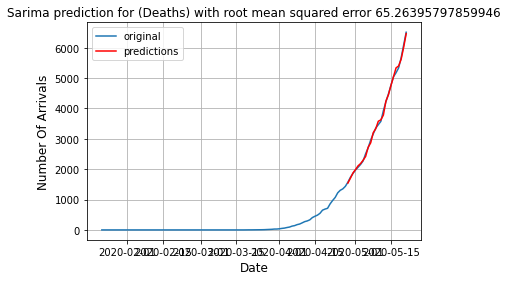

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testd, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [ ]:
mape(testd,predictions)

54.34983612708767